In [7]:
from astropy.table import Table, Column
import time
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import sys
from scipy.stats import kde
from tqdm import tqdm          
sys.path.insert(0, '../Modules')
import erqMedSpec
import erqScaling
import os
from  sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde


In [8]:
# Reading data
smp=Table.read('../LumMatch/LumMatch.fits')
iW3_0 = smp['i-w3']
kt80_0= smp['kurt80_gf']
rew_0 = smp['rew_gf']
rew_0  = np.log10(rew_0)
frat_0 = smp['frat_nv/civ']
fwhm_0 = smp['fwhm_gf']
iz_0 = iW3_0 - smp['r-w3'] + smp['r-z']

data_0 = np.array(list(zip(iW3_0, rew_0, kt80_0)))

In [9]:
# Scaling data with mean and std
data,minData,rangeData = erqScaling.MinMaxScaler(data_0)
data=data_0
MainCenter= np.median(data, axis=0)
x,y,z= data.T

In [10]:
# finding ERQs
ERQ = data[((iW3_0>=4.6) & (rew_0>=2))]
nonERQ = data[((iW3_0<4.6) | (rew_0<2))]
#  ERQ center
erqCenter= np.median(ERQ, axis=0)
#  distance of ERQ centroid from the main population centeriod 
r_erq = np.linalg.norm(erqCenter-MainCenter)
# unit vector to ERQs center from MCL
u_erq = erqCenter - MainCenter
u_erq = u_erq/np.linalg.norm(u_erq)

4.751156800229035
2919
1.2074182697257333e-06 4.750600888657177


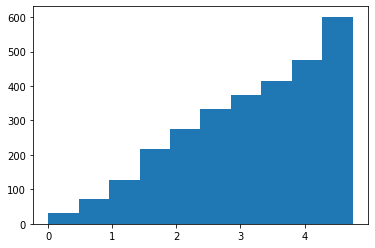

In [11]:
# building random vector pool on unit vectors for choosing those 
# that make an angle of Omega with ERQ vector
nPool=3000000
l=np.linspace(-1,1,nPool)
u_x = np.random.choice(l, nPool)
u_y = np.random.choice(l, nPool)
u_z = np.random.choice(l, nPool)
v = np.array(list(zip(u_x,u_y,u_z)))
v_normal = erqMedSpec.uniter(v)

# opening angle for a specific enclosing ratio
enclosing_ratio=0.85
Omega, theta_erq =erqMedSpec.opening_angle_finder(ERQ=ERQ, Main_center=MainCenter,
                                                  enclosing_ratio=enclosing_ratio, 
                                                  resolution=10000)
print(np.rad2deg(Omega))

#  Creating directions which have a deviation less than or equa Omega from ERQ vector
ConeDirections=[]
for i in range(len(v_normal)):
    if(np.arccos(np.dot(v_normal[i], u_erq))<=Omega):
        ConeDirections.append(v_normal[i])
ConeDirections.append(u_erq)
ConeDirections=np.array(ConeDirections)
print(len(ConeDirections))

# Cone vectors are vectors as long as erq vector extended length 
# vectors which we are going to calculate density along
extention=1.3
ConeVectors = ConeDirections*r_erq*extention + MainCenter
xf_cone, yf_cone, zf_cone= ConeVectors[:,0], ConeVectors[:,1], ConeVectors[:,2]
angle=np.rad2deg(np.arccos(np.dot(ConeDirections,u_erq)))

plt.hist(angle)
print(np.nanmin(angle), np.nanmax(angle))

In [12]:
#   density in 3d  for different bandwidths
lineSegment=200; nBootStrap=20
# den_med=np.zeros([ lineSegment])
# den_med=np.loadtxt('den-med-3d.txt')
r = np.linspace(0,extention, lineSegment) # normalized distance from MCl to any cone point by r_erq
# %matplotlib
kde= gaussian_kde(data.T)
bw= kde.factor

In [ ]:
# BootStarp resampling
from sklearn.model_selection import train_test_split
den_ens=[]
for ensemble in (range(nBootStrap)):
    print(ensemble)
    data_1, data_2 = train_test_split(data, test_size=0.5)
    for data_c in [data_1, data_2]:
        kde =gaussian_kde(data_c.T)
        kde.set_bandwidth(bw)
        den_con=[]
        for i in tqdm(range(len(xf_cone))):
            x=np.linspace(MainCenter[0],xf_cone[i], lineSegment)
            y=np.linspace(MainCenter[1],yf_cone[i], lineSegment)
            z=np.linspace(MainCenter[2],zf_cone[i], lineSegment)
            line = np.array(list(zip(x,y,z)))
            density = kde(line.T)
            den_con.append(density) 
            #density for each point along a line stored in a row of density_cone

        d = np.median(den_con, axis=0)
        den_ens.append(d)
        # median of each column gives the median density for a secific radius from center 
np.savetxt('BootStrapDensity-3d.dat',den_ens)

In [13]:
# Full sample kde
kde = gaussian_kde(data.T)
kde.set_bandwidth(bw)
den_max = max(kde(data.T))
den_con = []
for i in tqdm(range(len(xf_cone))):
    x=np.linspace(MainCenter[0],xf_cone[i], lineSegment)
    y=np.linspace(MainCenter[1],yf_cone[i], lineSegment)
    z=np.linspace(MainCenter[2],zf_cone[i], lineSegment)
    line = np.array(list(zip(x,y,z)))
    density = kde(line.T)
    den_con.append(density)

  3%|▎         | 83/2919 [00:10<06:09,  7.68it/s]

KeyboardInterrupt: 

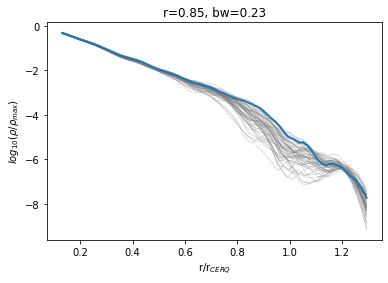

In [25]:
# Plotting
den_med = np.loadtxt('den-med-3d.txt')
cc=0
strat=20
for j in range(6):
    den_ens =np.loadtxt('B%d.dat'%j)
    for i in range(len(den_ens)):
        cc+=1
        if(np.log10(den_ens[i][-15])>=1.01*np.log10(den_med[-15])): 
            plt.plot(r[strat:-1], np.log10(den_ens[i][strat:-1]/np.max(den_ens[i][:])), alpha=0.5, lw=.5, c='gray')

# den_med = np.median(den_con, axis=0)
plt.plot(r[strat:-1], np.log10(den_med[strat:-1]/np.max(den_med)), alpha=1, lw=2)
plt.xlabel(r'r/r$_{CERQ}$')
plt.ylabel(r'$log_{10}(\rho/\rho_{max})$' )
plt.title('r=%.2f, bw=%.2f' %(enclosing_ratio,bw))
plt.savefig('cone-3d-density-bw-%.2f.pdf' %(bw))
# np.savetxt('den-med-3d.txt', den_med)

In [68]:
np.where(abs(r-1)<0.001)

(array([153]),)

In [18]:
lineSegment

200